# Probabilistic Network for the grades of Portugiese students

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 500)

## Preprocessing of the data
This part prepares the data for the model and learning process.

### Load and understand the dataset
The data are loaded and a histogram of the data is created to understand the data and how they correlate to each other.

In [2]:
DATA_PATH = "../data/"

original_data = pd.read_csv(DATA_PATH + "student-por_2.csv", sep=";")
original_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Unnamed: 33
0,MS,M,16,R,GT3,T,1,1,at_home,other,other,father,2,1,0,no,no,no,yes,yes,yes,no,no,3,4,4,3,4,5,6,11,11,11,"0,581558765"
1,MS,F,18,R,GT3,T,2,2,other,other,other,mother,2,1,1,no,no,no,no,yes,no,yes,yes,5,5,5,1,1,3,0,8,6,0,"0,677773943"
2,MS,M,17,R,GT3,T,1,1,other,services,course,mother,2,1,0,no,yes,no,yes,no,yes,yes,yes,4,5,5,1,3,2,0,10,9,10,"0,58860641"
3,GP,M,18,U,LE3,T,1,1,other,other,course,mother,1,1,2,no,no,no,no,yes,no,yes,yes,2,3,5,2,5,4,0,11,9,0,"0,627079796"
4,GP,F,18,U,GT3,T,2,1,other,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,yes,4,2,5,1,2,1,8,14,14,15,"0,459968853"


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   school       599 non-null    object
 1   sex          599 non-null    object
 2   age          599 non-null    int64 
 3   address      599 non-null    object
 4   famsize      599 non-null    object
 5   Pstatus      599 non-null    object
 6   Medu         599 non-null    int64 
 7   Fedu         599 non-null    int64 
 8   Mjob         599 non-null    object
 9   Fjob         599 non-null    object
 10  reason       599 non-null    object
 11  guardian     599 non-null    object
 12  traveltime   599 non-null    int64 
 13  studytime    599 non-null    int64 
 14  failures     599 non-null    int64 
 15  schoolsup    599 non-null    object
 16  famsup       599 non-null    object
 17  paid         599 non-null    object
 18  activities   599 non-null    object
 19  nursery      599 non-null    

### Check for false values and counts

In [4]:
with open(DATA_PATH + "values_counts.txt", "w") as f:
    for col in original_data.columns:
        unique_values = original_data[col].sort_values().unique()
        value_counts = original_data[col].value_counts()
        f.write(f"{col}: {unique_values} \n{value_counts}\n")
        f.write("-"*50)
        f.write("\n\n")

In [5]:
original_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,16.752922,2.489149,2.287145,1.564274,1.944908,0.230384,3.949917,3.183639,3.168614,1.489149,2.258765,3.545910,3.597663,11.414023,11.562604,11.909850
std,1.234558,1.135973,1.093161,0.748773,0.823141,0.601290,0.945414,1.048809,1.169548,0.906756,1.279430,1.443755,4.590239,2.754541,2.922466,3.267129
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


## Create numerical scales


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

data = original_data.copy()

# Delete the columns that are not useful
del data['Unnamed: 33']

# Binary columns to be converted to 0/1
data['school'] = data['school'].map({'GP': 0, 'MS': 1})
data['sex'] = data['sex'].map({'F': 0, 'M': 1})
data['address'] = data['address'].map({'U': 0, 'R': 1})
data['famsize'] = data['famsize'].map({'LE3': 0, 'GT3': 1})
data['Pstatus'] = data['Pstatus'].map({'T': 0, 'A': 1})
data['schoolsup'] = data['schoolsup'].map({'yes': 1, 'no': 0})
data['famsup'] = data['famsup'].map({'yes': 1, 'no': 0})
data['paid'] = data['paid'].map({'yes': 1, 'no': 0})
data['activities'] = data['activities'].map({'yes': 1, 'no': 0})
data['nursery'] = data['nursery'].map({'yes': 1, 'no': 0})
data['higher'] = data['higher'].map({'yes': 1, 'no': 0})
data['internet'] = data['internet'].map({'yes': 1, 'no': 0})
data['romantic'] = data['romantic'].map({'yes': 1, 'no': 0})

# Categories to be converted to one-hot encoding
converter = make_column_transformer((OneHotEncoder(), [
    # 'school',
    # 'sex',
    # 'address',
    'Mjob',
    'Fjob',
    'reason',
    'guardian',
    # 'traveltime',
    # 'studytime',
]), remainder='passthrough', verbose_feature_names_out=False)
converted = converter.fit_transform(data)
converted = pd.DataFrame(converted, columns=converter.get_feature_names_out())

# Remove label prefixes

converted.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mjob_at_home       599 non-null    float64
 1   Mjob_health        599 non-null    float64
 2   Mjob_other         599 non-null    float64
 3   Mjob_services      599 non-null    float64
 4   Mjob_teacher       599 non-null    float64
 5   Fjob_at_home       599 non-null    float64
 6   Fjob_health        599 non-null    float64
 7   Fjob_other         599 non-null    float64
 8   Fjob_services      599 non-null    float64
 9   Fjob_teacher       599 non-null    float64
 10  reason_course      599 non-null    float64
 11  reason_home        599 non-null    float64
 12  reason_other       599 non-null    float64
 13  reason_reputation  599 non-null    float64
 14  guardian_father    599 non-null    float64
 15  guardian_mother    599 non-null    float64
 16  guardian_other     599 non

In [7]:
converted.corr().style.background_gradient(cmap='coolwarm')

,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
Mjob_at_home,1.000000,-0.146053,-0.413874,-0.269068,-0.185626,0.139385,-0.073671,0.009273,-0.014723,-0.086903,0.134687,-0.082434,0.065308,-0.127969,-0.012210,-0.011265,0.041217,0.220128,-0.142403,0.080722,0.170575,-0.022863,-0.041013,-0.378282,-0.211156,0.192918,-0.049678,0.107015,-0.020749,-0.010375,-0.014332,-0.071546,-0.014529,-0.147323,-0.241699,0.040575,-0.020060,-0.016846,-0.039894,-0.018582,-0.028318,-0.085877,-0.025740,-0.173009,-0.146101,-0.132064
Mjob_health,-0.146053,1.000000,-0.224656,-0.146053,-0.100760,-0.049685,0.232633,-0.076196,0.023639,-0.009977,-0.110884,-0.012946,0.023542,0.128200,0.043511,-0.012950,-0.049685,-0.085286,0.016928,-0.094046,-0.093025,-0.005171,-0.025361,0.262038,0.136894,-0.126830,-0.004481,-0.054715,-0.055955,0.051247,0.007500,0.003291,0.024629,0.098235,0.095892,0.026423,-0.039266,-0.043235,0.036038,-0.088449,0.013087,0.013219,-0.093897,0.125051,0.127645,0.125394
Mjob_other,-0.413874,-0.224656,1.000000,-0.413874,-0.285525,-0.035107,-0.110168,0.235844,-0.147493,-0.098181,-0.033470,0.072941,-0.051103,0.005407,0.067666,-0.118100,0.102068,0.033788,-0.019166,0.051550,0.046264,0.074968,0.020990,-0.247309,-0.206622,0.034439,-0.009008,0.007527,0.056592,-0.109376,-0.034030,-0.069441,-0.094267,-0.029905,-0.065813,0.029907,0.006052,-0.002575,0.010880,-0.011232,-0.043642,-0.012337,0.042368,-0.050350,-0.055220,-0.072376
Mjob_services,-0.269068,-0.146053,-0.413874,1.000000,-0.185626,-0.024228,-0.005466,-0.130820,0.158025,0.003912,-0.037876,-0.023627,0.000087,0.069109,-0.021910,0.069170,-0.089673,-0.122646,0.065827,-0.035168,-0.102666,-0.022863,0.046905,0.147100,0.117914,-0.074590,0.034746,0.018636,0.032138,0.073605,0.053533,0.075502,0.037151,0.036524,0.143399,-0.069784,0.040474,0.002642,0.047486,0.058057,0.041973,0.058523,0.071330,0.046627,0.030142,0.041851
Mjob_teacher,-0.185626,-0.100760,-0.285525,-0.185626,1.000000,-0.053564,0.079958,-0.143173,0.022588,0.266020,0.017888,0.035208,-0.025084,-0.037898,-0.095810,0.117536,-0.053564,-0.107390,0.114198,-0.060575,-0.082095,-0.052042,-0.018992,0.462438,0.325098,-0.101085,0.036768,-0.128467,-0.055629,0.044474,-0.004379,0.098915,0.095468,0.107931,0.148938,-0.030056,-0.003311,0.057814,-0.056139,0.039138,0.038713,0.043333,-0.046633,0.137378,0.129298,0.124342
Fjob_at_home,0.139385,-0.049685,-0.035107,-0.024228,-0.053564,1.000000,-0.049716,-0.305448,-0.167009,-0.063549,0.109927,-0.047313,-0.030058,-0.061547,0.012462,-0.030928,0.035599,0.154949,-0.042188,0.053581,-0.021467,-0.037163,0.003948,-0.097606,-0.100938,-0.031920,-0.006475,0.030996,0.015721,0.046186,-0.013078,0.043254,0.029552,-0.100184,-0.119554,0.006149,-0.084931,0.048848,0.007185,-0.026322,-0.048916,-0.050236,0.027840,-0.096127,-0.079022,-0.047925
Fjob_health,-0.073671,0.232633,-0.110168,-0.005466,0.079958,-0.049716,1.000000,-0.212221,-0.116036,-0.044153,-0.054496,-0.055172,0.023634,0.102965,0.074865,-0.041822,-0.049716,-0.077565,-0.038787,-0.105909,-0.085104,-0.005281,-0.011545,0.149148,0.231902,-0.115335,0.091541,-0.055802,0.086128,0.108518,-0.009086,0.002172,0.067565,0.064843,0.037409,-0.024699,0.000016,-0.068040,-0.010913,-0.049059,-0.044890,0.077830,-0.024219,0.083464,0.081941,0.070607
Fjob_other,0.009273,-0.076196,0.235844,-0.130820,-0.143173,-0.305448,-0.212221,1.000000,-0.712901,-0.271267,-0.021054,0.074068,-0.079091,0.010528,-0.136789,0.071772,0.099338,-0.058530,-0.023302,0.053956,0.052108,-0.019787,0.085474,-0.127078,-0.220008,0.097748,-0.034090,0.038684,-0.013307,-0.061175,0.014833,-0.084343,-0.045608,-0.023973,-0.001604,0.011372,0.017751,0.028113,0.028362,-0.032796,-0.007

In [8]:
indices = [
    'Dalc',
    'Walc',
]
converted[indices + ['G3']].corr().style.background_gradient(cmap='coolwarm')

,Dalc,Walc,G3
Dalc,1.000000,0.609985,-0.186606
Walc,0.609985,1.000000,-0.162832
G3,-0.186606,-0.162832,1.000000


## Create Network

/home/tom/projects/probability-ki/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


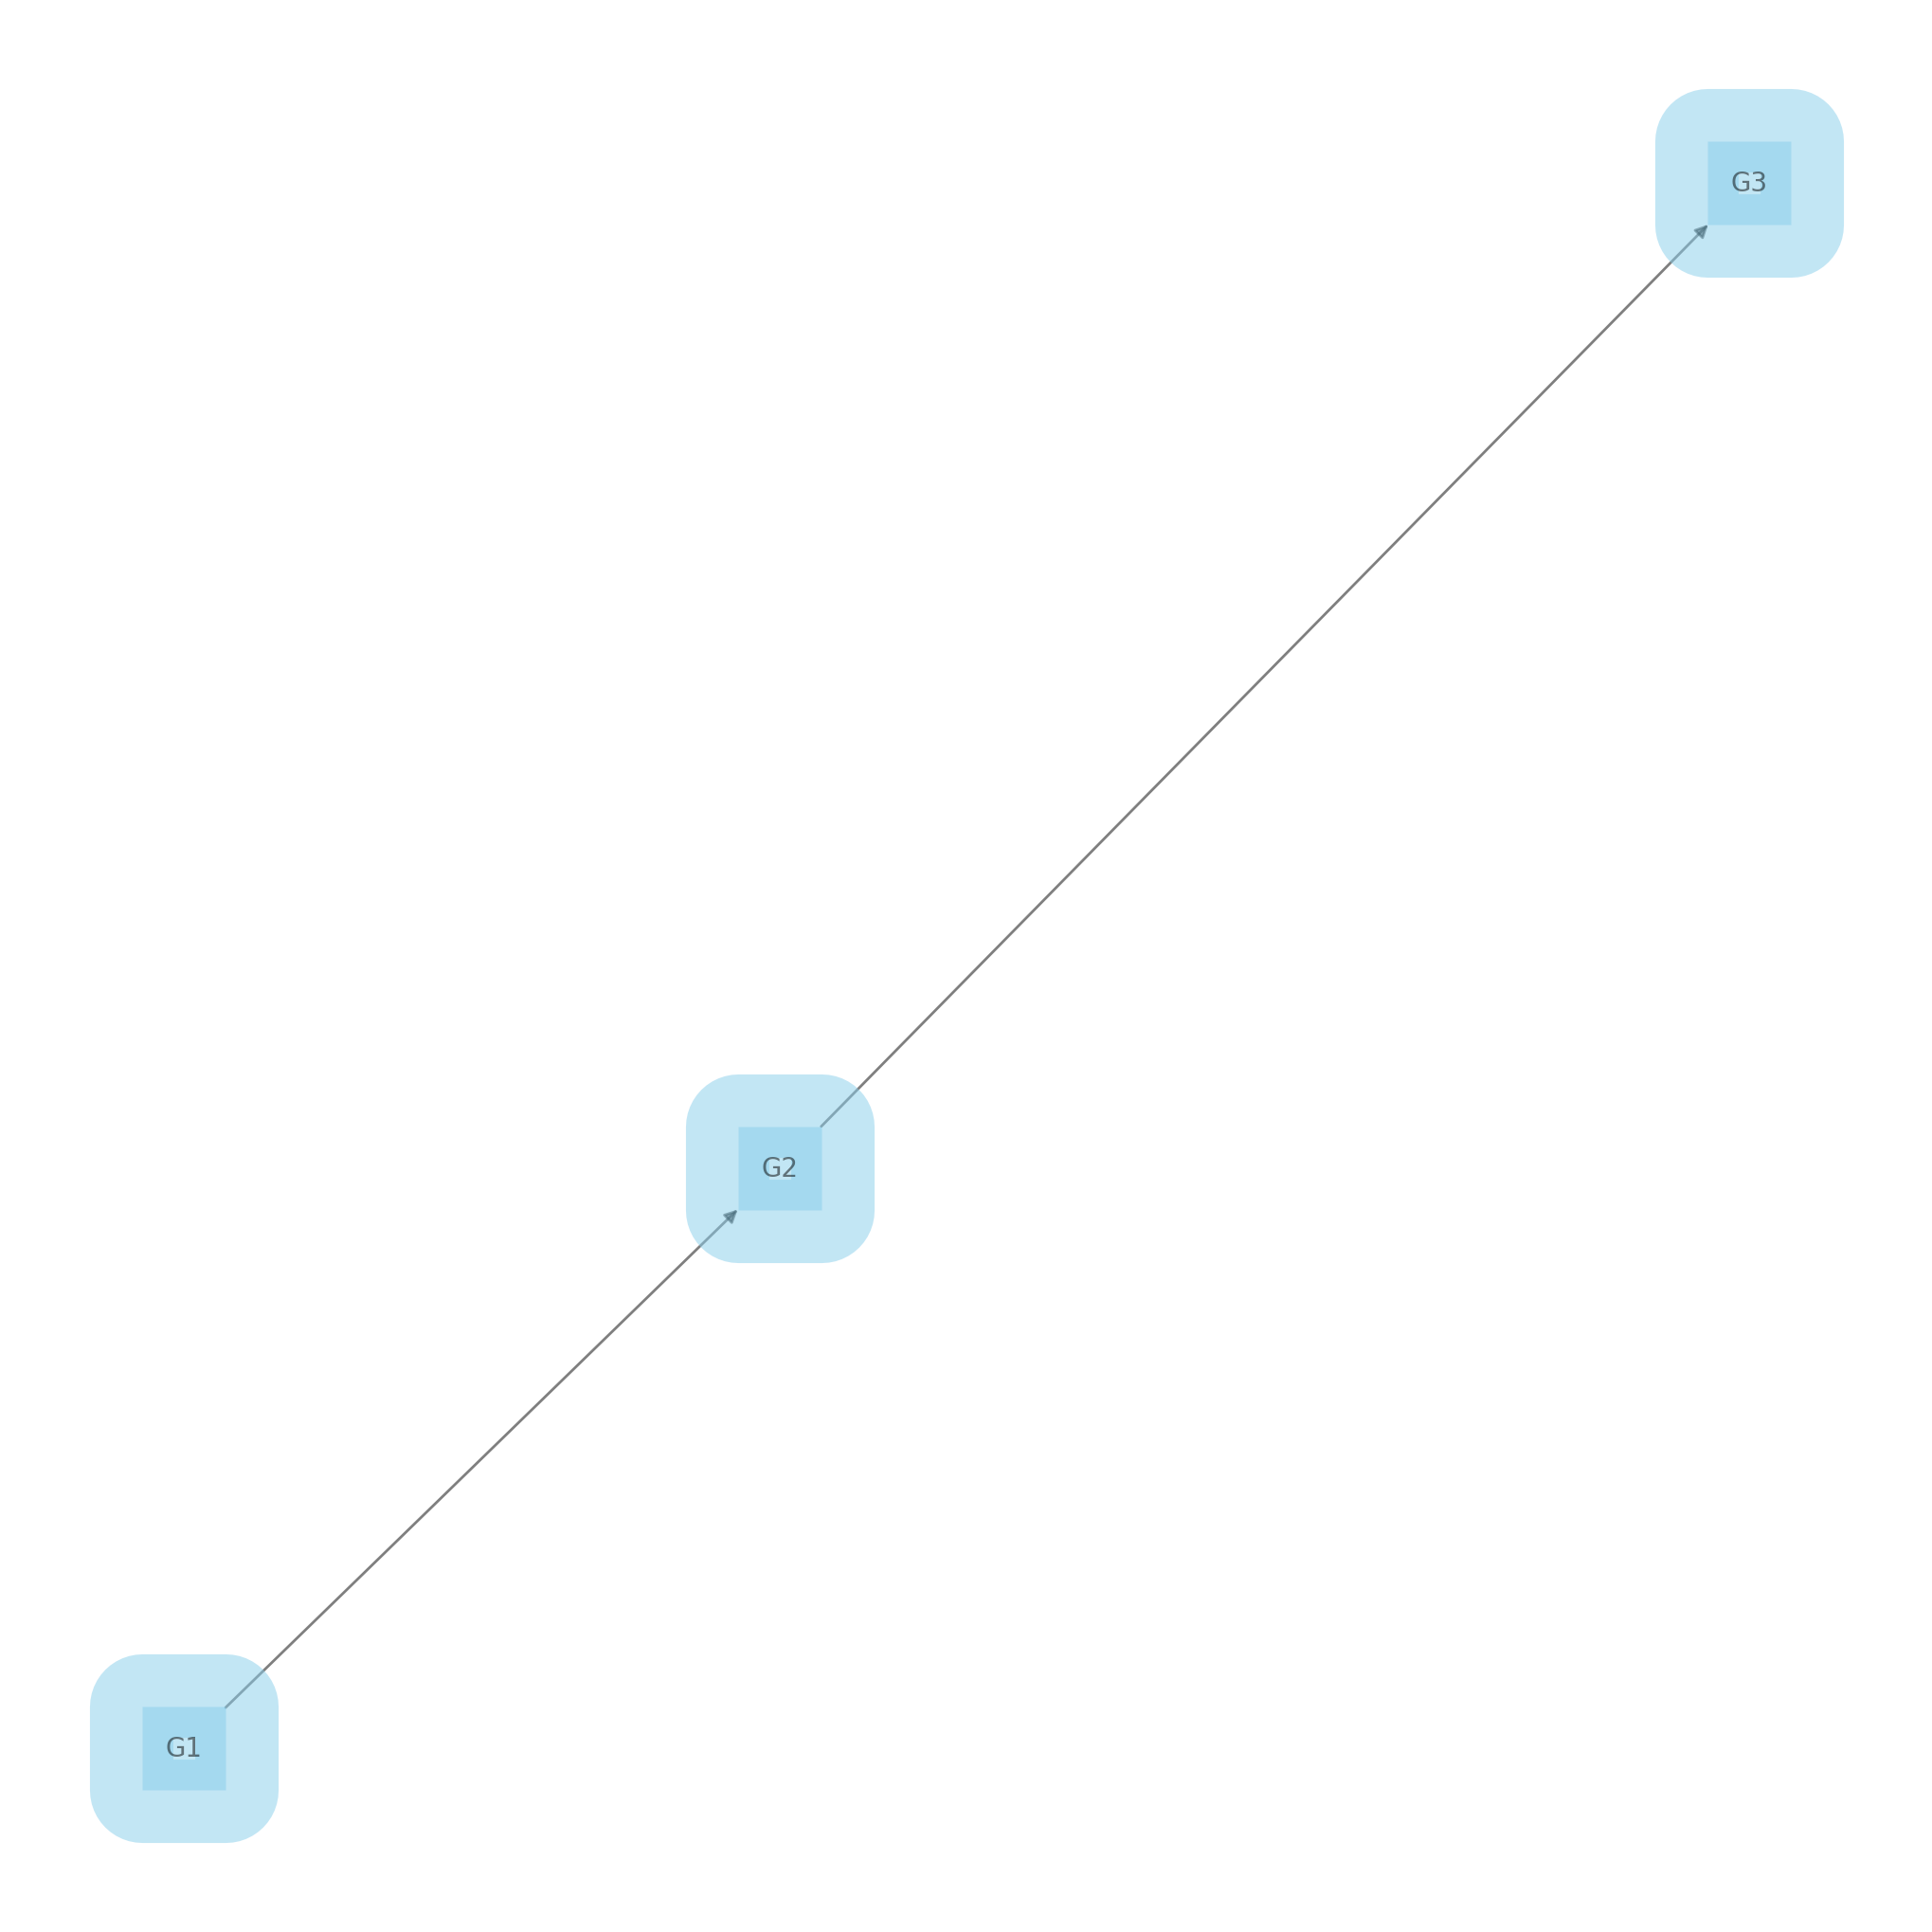

In [9]:
from pgmpy.models import BayesianNetwork

model_data = original_data.copy()
del model_data['Unnamed: 33']

# Create Network
network = BayesianNetwork()

# Add all columns as nodes
for col in model_data.columns:
    network.add_node(col)
    
    
# Add edges
# network.add_edge('Fedu', 'Fjob')
# network.add_edge('Medu', 'Mjob')
# network.add_edge('Medu', 'Fjob')
# network.add_edge('Fedu', 'Mjob')

# network.add_edge('Mjob', 'higher')
# network.add_edge('Fjob', 'higher')
# network.add_edge('Mjob', 'paid')
# network.add_edge('Fjob', 'paid')
# network.add_edge('Mjob', 'internet')
# network.add_edge('Fjob', 'internet')
# network.add_edge('Mjob', 'school')
# network.add_edge('Fjob', 'school')
# network.add_edge('Mjob', 'famsup')
# network.add_edge('Fjob', 'famsup')
# # network.add_edge('Mjob', 'G1')
# # network.add_edge('Fjob', 'G1')
# # network.add_edge('Mjob', 'G2')
# # network.add_edge('Fjob', 'G2')

# network.add_edge('sex', 'famrel')
# network.add_edge('sex', 'romantic')
# network.add_edge('sex', 'famsup')
# network.add_edge('sex', 'schoolsup')
# network.add_edge('sex', 'Dalc')
# network.add_edge('sex', 'Walc')
# network.add_edge('sex', 'activities')

# network.add_edge('age', 'romantic')
# network.add_edge('age', 'Dalc')
# network.add_edge('age', 'Walc')
# network.add_edge('age', 'guardian')
# network.add_edge('age', 'higher')
# network.add_edge('age', 'failures')
# network.add_edge('age', 'absences')
# network.add_edge('age', 'studytime')
# network.add_edge('age', 'famsup')

# network.add_edge('address', 'school')
# network.add_edge('address', 'traveltime')

# network.add_edge('reason', 'school')

# network.add_edge('school', 'studytime')
# network.add_edge('school', 'absences')
# network.add_edge('school', 'traveltime')
# network.add_edge('school', 'internet')

# network.add_edge('famsup', 'studytime')

# network.add_edge('higher', 'G1')
# network.add_edge('higher', 'G2')
# network.add_edge('higher', 'Dalc')
# network.add_edge('higher', 'Walc')
# network.add_edge('higher', 'freetime')
# network.add_edge('higher', 'failures')
# network.add_edge('higher', 'absences')
# network.add_edge('higher', 'studytime')

# network.add_edge('Pstatus', 'famsize')
# network.add_edge('Pstatus', 'guardian')

# network.add_edge('famsize', 'nursery')

# network.add_edge('activities', 'freetime')

# network.add_edge('famrel', 'freetime')
# network.add_edge('famrel', 'health')

 
# network.add_edge('Dalc', 'health')
# network.add_edge('Dalc', 'goout')
# network.add_edge('Dalc', 'G1')
# network.add_edge('Dalc', 'G2')
# network.add_edge('Dalc', 'absences')
# network.add_edge('Dalc', 'studytime')

# network.add_edge('Walc', 'health')
# network.add_edge('Walc', 'goout')
# network.add_edge('Walc', 'G1')
# network.add_edge('Walc', 'G2')
# network.add_edge('Walc', 'absences')
# network.add_edge('Walc', 'studytime')

# network.add_edge('schoolsup', 'studytime')

# network.add_edge('internet', 'G1')
# network.add_edge('internet', 'G2')

# network.add_edge('absences', 'studytime')
# network.add_edge('absences', 'failures')
# network.add_edge('absences', 'G1')
# network.add_edge('absences', 'G2')

# network.add_edge('goout', 'freetime')


# network.add_edge('freetime', 'G1')
# network.add_edge('freetime', 'G2')
# network.add_edge('freetime', 'failures')

# network.add_edge('failures', 'G1')
# network.add_edge('failures', 'G2')

# network.add_edge('studytime', 'failures')
# network.add_edge('studytime', 'G1')
# network.add_edge('studytime', 'G2')

network.add_edge('G1', 'G2')
network.add_edge('G2', 'G3')

# Draw network
nx_graph = nx.DiGraph(network.edges())
plt.figure(figsize=(10, 10))
nx.draw(nx_graph, with_labels=True, node_size=1000, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40, font_size=10)
plt.show()


# Fit data
network.fit(model_data)



In [10]:
# from pgmpy.factors.discrete.CPD import TabularCPD

# # Create CPDs
# cpds = network.get_cpds()

# for cpd in cpds:
#     print(cpd)

In [11]:
test_data = pd.read_csv(DATA_PATH + "student-por_2.csv", sep=";")
# test_data = test_data.loc[[i for i in range(0, 100)]]

del test_data['Unnamed: 33']

label = test_data['G3']
del test_data['G3']
del test_data['G2']

# Predict
results = network.predict(test_data, stochastic=False, n_jobs=10)

100%|██████████| 599/599 [00:02<00:00, 202.94it/s]


## Evaluation

In [14]:
MATCH_LESS_EQUAL = 0

def distance(a, b):
    return abs(a - b)

def accuracy(results, label):
    correct = 0
    for i in range(len(results)):
        if distance(results.loc[i, 'G3'], label[i]) <= MATCH_LESS_EQUAL:
            correct += 1
    return correct / len(results)

def average_error(results, label):
    error = 0
    for i in range(len(results)):
        error += distance(results.loc[i, 'G3'], label[i])
    return error / len(results)

def average_error_without_match(results, label):
    error = 0
    count = 0
    for i in range(len(results)):
        if distance(results.loc[i, 'G3'], label[i]) > MATCH_LESS_EQUAL:
            error += distance(results.loc[i, 'G3'], label[i])
            count += 1
    return error / count

def loss(results, label):
    error = 0
    for i in range(len(results)):
        error += distance(results.loc[i, 'G3'], label[i]) ** 2
    return error / len(results)

ac = accuracy(results, label)
av_err = average_error(results, label)
av_err_without = average_error_without_match(results, label)
print(f"Accuracy: {ac}, Average Error: {av_err}, Average Error Without Match: {av_err_without}, Loss: {loss(results, label)}")

Accuracy: 0.337228714524207, Average Error: 1.2404006677796326, Average Error Without Match: 1.871536523929471, Loss: 4.25542570951586


Get the values of all with an error higher than 1

In [15]:
count = 0
for i in range(len(results)):
    if distance(results.loc[i, 'G3'], label[i]) <= 1:
        continue
    count += 1
print(count)

# print 5 badest predictions
for i in range(len(results)):
    if distance(results.loc[i, 'G3'], label[i]) <= 10:
        continue
    print(f"Predicted: {results.loc[i, 'G3']}, Actual: {label[i]}, Data: \n{test_data.loc[i]}")

175
Predicted: 11, Actual: 0, Data: 
school            GP
sex                M
age               18
address            U
famsize          LE3
Pstatus            T
Medu               1
Fedu               1
Mjob           other
Fjob           other
reason        course
guardian      mother
traveltime         1
studytime          1
failures           2
schoolsup         no
famsup            no
paid              no
activities        no
nursery          yes
higher            no
internet         yes
romantic         yes
famrel             2
freetime           3
goout              5
Dalc               2
Walc               5
health             4
absences           0
G1                11
Name: 3, dtype: object
